## Load and Visualize the Dataset

Dataset Link: [Kaggle-Butterfly Image Classification dataset](https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification)

### Load Images

In [1]:
IMG_SIZE = (227, 227)

In [2]:
import pandas as pd
import tensorflow as tf
from PIL import Image
import numpy as np

pd.options.mode.chained_assignment = None

def load_img(img_path):
    img = Image.open(img_path)
    img = img.resize(IMG_SIZE)
    img_arr = np.array(img)
    return img_arr

ind_to_label = list()
label_to_ind = dict()

def load_ds(path, random_state=42):
    df = pd.read_csv(path + 'Training_set.csv')
    df = df.sample(frac=1, random_state=random_state)
    val_df = df[6000:]
    train_df = df[:6000]
    
    img_dir = path + 'train/'
    train_df['filepath'] = train_df['filename'].map(lambda x: img_dir + x)
    val_df['filepath'] = val_df['filename'].map(lambda x: img_dir + x)

    train_df['img'] = train_df['filepath'].map(load_img) / 255.
    val_df['img'] = val_df['filepath'].map(load_img) / 255.

    labels = set(train_df['label'])

    ind_to_label = list(labels)
    
    for i in range(0, len(ind_to_label)):
        label_to_ind[ind_to_label[i]] = i
    
    train_df['y'] = train_df['label'].map(lambda x: label_to_ind[x])
    val_df['y'] = val_df['label'].map(lambda x:label_to_ind[x])
    
    return train_df, val_df, labels

2025-04-17 02:44:53.681037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744857893.868280      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744857893.920313      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_df, val_df, labels = load_ds('/kaggle/input/butterfly-image-classification/')

In [5]:
train_df.head(2)

,filename,label,filepath,img,y
5572,Image_5573.jpg,GREEN CELLED CATTLEHEART,/kaggle/input/butterfly-image-classification/t...,"[[[0.9333333333333333, 0.9333333333333333, 0.9...",44
1703,Image_1704.jpg,MONARCH,/kaggle/input/butterfly-image-classification/t...,"[[[0.45098039215686275, 0.5294117647058824, 0....",74


### Visualize images

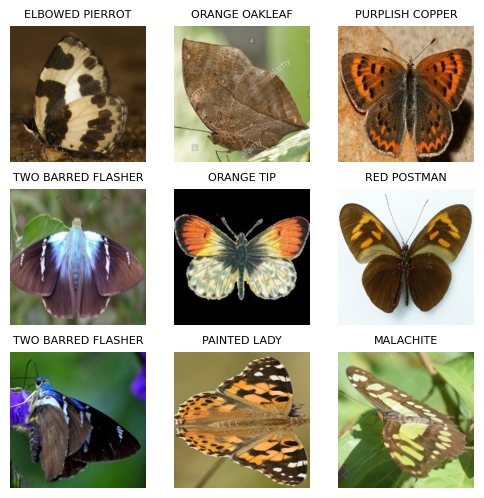

In [6]:
import matplotlib.pyplot as plt
import random

f, ax = plt.subplots(3, 3, figsize=(6, 6))

for i in range(0, 9):
    img_ind = random.randint(0, len(train_df))
    data_pt = train_df.iloc[img_ind]
    ax[i//3][i%3].imshow(data_pt['img'])
    ax[i//3][i%3].set_title(data_pt['label'], fontsize=8)
    ax[i//3][i%3].axis('off')

## Model architecture

In [4]:
INPUT_SHAPE = IMG_SIZE + (3,)
INPUT_SHAPE

(227, 227, 3)

### Naive model

In [8]:
from functools import partial

def make_naive_model():
    DefaultConv2D = partial(
        tf.keras.layers.Conv2D,
        activation='tanh',
        kernel_size=3,
        padding='same',
        kernel_initializer='he_normal',
    )
    
    input = tf.keras.layers.Input(shape=INPUT_SHAPE)
    x = tf.keras.layers.Normalization()(input)
    x = DefaultConv2D(filters=64)(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = DefaultConv2D(filters=128)(x)
    x = DefaultConv2D(filters=128)(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = DefaultConv2D(filters=256)(x)
    x = DefaultConv2D(filters=256)(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units=200)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(units=100)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(units=100)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(units=100)(x)
    x = tf.keras.layers.Dense(units=len(labels))(x)
    
    return tf.keras.Model(inputs=input, outputs=x)

model = make_naive_model()
model.summary()

I0000 00:00:1744607945.850672      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744607945.851341      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 227, 227, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 227, 227, 3)         │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 227, 227, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 113, 113, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 113, 113, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 200)                 │      40,141,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 75)                  │           7,575 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,297,362 (157.54 MB)

 Trainable params: 41,297,355 (157.54 MB)

 Non-trainable params: 7 (32.00 B)

### AlexNet

In [9]:
from functools import partial

DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    activation='relu',
    kernel_size=3,
    padding='valid',
    kernel_initializer='he_normal',
)

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE, name='input'),
    DefaultConv2D(kernel_size=11, filters=96, strides=(4, 4), name='C1'),
    tf.keras.layers.Lambda(tf.nn.local_response_normalization),
    tf.keras.layers.MaxPool2D(name='S2'),
    DefaultConv2D(kernel_size=5, filters= 256, padding='same', name='C3'),
    tf.keras.layers.Lambda(tf.nn.local_response_normalization),
    tf.keras.layers.MaxPool2D(name='S4'),
    DefaultConv2D(filters=384, padding='same', name='C5'),
    DefaultConv2D(filters=384, padding='same', name='C6'),
    DefaultConv2D(filters=256, padding='same', name='C7'),
    tf.keras.layers.MaxPool2D(name='S8'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=4096, activation='relu', name='F9'),
    tf.keras.layers.Dense(units=4096, activation='relu', name='F10'),
    tf.keras.layers.Dense(units=len(labels), activation='softmax', name='output'),
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ C1 (Conv2D)                          │ (None, 55, 55, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 55, 55, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ S2 (MaxPooling2D)                    │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ C3 (Conv2D)                          │ (None, 27, 27, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 27, 27, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ S4 (MaxPooling2D)                    │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ C5 (Conv2D)                          │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ C6 (Conv2D)                          │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ C7 (Conv2D)                          │ (None, 13, 13, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ S8 (MaxPooling2D)                    │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ F9 (Dense)                           │ (None, 4096)                │      37,752,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ F10 (Dense)                          │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 75)                  │         307,275 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,588,619 (223.50 MB)

 Trainable params: 58,588,619 (223.50 MB)

 Non-trainable params: 0 (0.00 B)

### Pretrained Xception Net

In [5]:
import tensorflow as tf

base_model = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=INPUT_SHAPE,
    pooling=None,
)

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(labels)),
])

model.summary()

I0000 00:00:1744857984.884261      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 75)                  │       7,526,475 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,387,955 (108.29 MB)

 Trainable params: 28,333,427 (108.08 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [6]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
    optimizer='adam'
)

## Training model

In [7]:
train_X = np.stack(train_df['img'].values)
train_Y = train_df['y'].values

val_X = np.stack(val_df['img'].values)
val_Y = val_df['y'].values

print(train_X.shape, train_Y.shape)
print(val_X.shape, val_Y.shape)

(6000, 227, 227, 3) (6000,)
(499, 227, 227, 3) (499,)


In [8]:
model.fit(
    x=train_X,
    y=train_Y,
    validation_data=(val_X, val_Y),
    epochs=10,
    batch_size=32
)

Epoch 1/10


I0000 00:00:1744858033.659593      92 service.cc:148] XLA service 0x7dad74005720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744858033.660932      92 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744858036.905022      92 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1744858047.096821      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744858047.297740      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744858048.343077      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744858048.5297

187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.0485 - loss: 4.3985

E0000 00:00:1744858113.171320      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744858113.367385      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744858114.076360      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744858114.261077      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744858114.865333      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

188/188 ━━━━━━━━━━━━━━━━━━━━ 131s 389ms/step - accuracy: 0.0494 - loss: 4.3921 - val_accuracy: 0.1283 - val_loss: 11.0284
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 49s 259ms/step - accuracy: 0.5396 - loss: 1.6920 - val_accuracy: 0.5852 - val_loss: 2.5856
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 49s 258ms/step - accuracy: 0.8105 - loss: 0.6131 - val_accuracy: 0.6854 - val_loss: 1.6056
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 49s 258ms/step - accuracy: 0.8767 - loss: 0.4267 - val_accuracy: 0.6192 - val_loss: 1.8362
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 49s 258ms/step - accuracy: 0.9034 - loss: 0.3188 - val_accuracy: 0.7134 - val_loss: 1.3317
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 48s 258ms/step - accuracy: 0.9057 - loss: 0.3334 - val_accuracy: 0.7134 - val_loss: 1.5733
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 49s 258ms/step - accuracy: 0.9204 - loss: 0.2529 - val_accuracy: 0.6754 - val_loss: 2.7514
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 49s 258ms/step - accuracy: 0.9476 - loss: 0.1720 - v